In [1]:
#Random forest: https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56

In [2]:
!pip install imblearn==0.0

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE

In [4]:
#the file that contains all issues and all fields
allBounty = pd.read_csv("dataset/gitcoin_dataset_5.csv")

#the file that contains fields from 'activities' array e.g. activity_type, duration_create_to_done
activity_coll = pd.read_csv("dataset/activities_collection_3.csv")

#the file that contains '# of times bounty increased' from 'activities' array
bounty_changed = pd.read_csv("dataset/changedBounty2.csv")

In [5]:
#Cleansing data

activity_coll.drop('duration_worker_applied_to_worker_approved',axis='columns', inplace=True)

#fill-in 'numerical values' with their median
allBounty['value_in_eth'].fillna(float(allBounty['value_in_eth'].median()), inplace = True)
allBounty['value_in_usdt_now'].fillna(float(allBounty['value_in_usdt_now'].median()), inplace = True)
allBounty['value_in_usdt'].fillna(float(allBounty['value_in_usdt'].median()), inplace = True)
allBounty['token_value_in_usdt'].fillna(float(allBounty['token_value_in_usdt'].median()), inplace = True)

#fill-in 'categorical values' with "NA" (except for github_issue_number)
allBounty['title'].fillna("NA", inplace = True)
allBounty['funder_last_messaged_on'].fillna("NA", inplace = True)
allBounty['is_reserved'].fillna("NA", inplace = True)
allBounty['canceled_bounty_reason'].fillna("NA", inplace = True)
allBounty['reserved_for_user_handle'].fillna("NA", inplace = True)
allBounty['attached_job_description'].fillna("NA", inplace = True)
allBounty['canceled_on'].fillna("NA", inplace = True)
allBounty['funding_organisation'].fillna("NA", inplace = True)
allBounty['featuring_date'].fillna("NA", inplace = True)
allBounty['fulfillment_accepted_on'].fillna("NA", inplace = True)
allBounty['fulfillment_submitted_on'].fillna("NA", inplace = True)
allBounty['fulfillment_started_on'].fillna("NA", inplace = True)
allBounty['keywords'].fillna("NA", inplace = True)
allBounty['bounty_owner_name'].fillna("NA", inplace = True)
allBounty['github_issue_state'].fillna("NA", inplace = True)
allBounty['bounty_owner_github_username'].fillna("NA", inplace = True)
allBounty['bounty_owner_email'].fillna("NA", inplace = True)
allBounty['github_issue_number'].fillna(0, inplace = True)
allBounty['github_repo_name'].fillna("NA", inplace = True)
allBounty['org_name'].fillna("NA", inplace = True)
allBounty['github_org_name'].fillna("NA", inplace = True)

allBounty.loc[allBounty['bounty_type'] == "0", 'bounty_type'] = "Other"
allBounty.loc[allBounty['bounty_type'] == "Andere", 'bounty_type'] = "Other"
allBounty.loc[allBounty['bounty_type'] == "Funkcja", 'bounty_type'] = "Other"
allBounty.loc[allBounty['bounty_type'] == "æ¹å", 'bounty_type'] = "Other"
allBounty['bounty_type'].fillna("NA", inplace = True)

allBounty.loc[allBounty['experience_level'] == "0", 'experience_level'] = "Other"
allBounty.loc[allBounty['experience_level'] == "Mittlere", 'experience_level'] = "Intermediate"
allBounty.loc[allBounty['experience_level'] == "åå¿è", 'experience_level'] = "Other"
allBounty.loc[allBounty['experience_level'] == "Pośredni", 'experience_level'] = "Intermediate"
allBounty['experience_level'].fillna("NA", inplace = True)

allBounty.loc[allBounty['project_length'] == "0", 'project_length'] = "Unknown"
allBounty.loc[allBounty['project_length'] == "Tage", 'project_length'] = "Days"
allBounty.loc[allBounty['project_length'] == "Miesięcy", 'project_length'] = "Months"
allBounty['project_length'].fillna("NA", inplace = True)

In [6]:
#merge two dataframe together
outer_merged = pd.merge(allBounty, activity_coll, how="outer", on=["pk"])
outer_merged = pd.merge(outer_merged, bounty_changed, how="outer", on=["pk"])

outer_merged['increased_bounty_times'].fillna(0, inplace = True)
outer_merged['changed_bounty_value'].fillna(0, inplace = True)

outer_merged['firstAct_activity_type'].fillna("NA", inplace = True)
outer_merged['lastAct_activity_type'].fillna("NA", inplace = True)

outer_merged['duration_create_to_done'].fillna(0, inplace = True)
outer_merged['duration_create_to_firstAct'].fillna(0, inplace = True)
outer_merged['duration_create_to_killed'].fillna(0, inplace = True)
outer_merged['duration_create_to_lastAct'].fillna(0, inplace = True)
outer_merged['duration_create_to_new_bounty'].fillna(0, inplace = True)
outer_merged['duration_create_to_start'].fillna(0, inplace = True)
outer_merged['duration_create_to_stop'].fillna(0, inplace = True)
outer_merged['duration_create_to_submitted'].fillna(0, inplace = True)
outer_merged['duration_create_to_worker_applied'].fillna(0, inplace = True)
outer_merged['number_of_user_in_activities'].fillna(0, inplace = True)

In [7]:
#change cathegory to number

#experience_level
outer_merged['experience_level_code'] = outer_merged['experience_level']
find_replace = {"experience_level_code" : {"NA": 0, "Other": 0, "Beginner": 1, "Intermediate": 2, "Advanced": 3}}
outer_merged.replace(find_replace, inplace=True)

#project_length
outer_merged['project_length_code'] = outer_merged['project_length']
find_replace = {"project_length_code" : {"NA": 0, "Unknown": 0, "Hours": 1, "Days": 24, "Weeks": 168, "Months": 720}} #in hours
outer_merged.replace(find_replace, inplace=True)

In [8]:
#normalization
#https://towardsdatascience.com/everything-you-need-to-know-about-min-max-normalization-in-python-b79592732b79
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler() 
column_names_to_normalize = ['changed_bounty_value','github_comments','increased_bounty_times','description_length','duration_create_to_expire','number_of_activities','number_of_fulfillments','number_of_interests','token_value_in_usdt','value_in_eth','value_in_token','value_in_usdt','value_in_usdt_now','duration_create_to_done','duration_create_to_firstAct','duration_create_to_killed','duration_create_to_lastAct','duration_create_to_new_bounty','duration_create_to_start','duration_create_to_stop','duration_create_to_submitted','duration_create_to_worker_applied','number_of_user_in_activities']
x = outer_merged[column_names_to_normalize].values
x_scaled = min_max_scaler.fit_transform(x)
outer_merged_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = outer_merged.index)
outer_merged[column_names_to_normalize] = outer_merged_temp

In [9]:
pd.set_option('display.max_columns', None)
outer_merged_temp.describe()
outer_merged_temp.shape
outer_merged.describe()
outer_merged.shape

,changed_bounty_value,github_comments,increased_bounty_times,description_length,duration_create_to_expire,number_of_activities,number_of_fulfillments,number_of_interests,token_value_in_usdt,value_in_eth,value_in_token,value_in_usdt,value_in_usdt_now,duration_create_to_done,duration_create_to_firstAct,duration_create_to_killed,duration_create_to_lastAct,duration_create_to_new_bounty,duration_create_to_start,duration_create_to_stop,duration_create_to_submitted,duration_create_to_worker_applied,number_of_user_in_activities
count,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000
mean,0.000841,0.084412,0.004005,0.051541,0.102374,0.031279,0.010140,0.014849,0.007655,0.000589,5.869119e-04,0.000609,0.000620,0.032849,0.003017,0.023449,0.219392,0.362647,0.006785,0.016800,0.078956,0.009370,0.025320
std,0.018127,0.117538,0.025336,0.056217,0.274589,0.049440,0.039168,0.040416,0.024649,0.020894,1.702679e-02,0.020923,0.020905,0.075719,0.029698,0.086083,0.226041,0.046084,0.040718,0.061074,0.187339,0.051110,0.045570
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000045,0.010638,0.000000,0.015718,0.000242,0.012500,0.000000,0.006024,0.000028,0.000010,1.361610e-08,0.000012,0.000010,0.000000,0.001304,0.000000,0.023263,0.355253,0.000000,0.000000,0.000000,0.000831,0.011765
50%,0.000045,0.042553,0.000000,0.033951,0.000259,0.020000,0.006410,0.006024,0.003430,0.000026,1.270836e-07,0.000029,0.000026,0.003132,0.001306,0.000000,0.118539,0.355684,0.000000,0.000000,0.005193,0.000835,0.017647
75%,0.000045,0.117021,0.000000,0.068522,0.003145,0.032500,0.006410,0.012048,0.008937,0.000071,1.089288e-05,0.000079,0.000079,0.031154,0.001310,0.000000,0.393087,0.356496,0.000562,0.007055,0.030450,0.001513,0.023529
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


(4584, 23)

,description_length,duration_create_to_expire,github_comments,github_issue_number,is_paid,is_success,number_of_activities,number_of_fulfillments,number_of_interests,pk,standard_bounties_id,token_value_in_usdt,value_in_eth,value_in_token,value_in_usdt,value_in_usdt_now,value_true,duration_create_to_done,duration_create_to_firstAct,duration_create_to_killed,duration_create_to_lastAct,duration_create_to_new_bounty,duration_create_to_start,duration_create_to_stop,duration_create_to_submitted,duration_create_to_worker_applied,number_of_user_in_activities,increased_bounty_times,changed_bounty_value,experience_level_code,project_length_code
count,4584.000000,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000
mean,0.051541,0.102374,0.084412,2.752041e+03,0.580716,0.580716,0.031279,0.010140,0.014849,14940.176483,1.689004e+07,0.007655,0.000589,5.869119e-04,0.000609,0.000620,1.759311e+04,0.032849,0.003017,0.023449,0.219392,0.362647,0.006785,0.016800,0.078956,0.009370,0.025320,0.004005,0.000841,1.578098,20.155541
std,0.056217,0.274589,0.117538,1.214674e+05,0.493496,0.493496,0.049440,0.039168,0.040416,6748.159187,3.747219e+07,0.024649,0.020894,1.702679e-02,0.020923,0.020905,7.617667e+05,0.075719,0.029698,0.086083,0.226041,0.046084,0.040718,0.061074,0.187339,0.051110,0.045570,0.025336,0.018127,0.903123,62.679123
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,7.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.015718,0.000242,0.010638,9.000000e+00,0.000000,0.000000,0.012500,0.000000,0.006024,10345.750000,1.415750e+03,0.000028,0.000010,1.361610e-08,0.000012,0.000010,2.500000e-01,0.000000,0.001304,0.000000,0.023263,0.355253,0.000000,0.000000,0.000000,0.000831,0.011765,0.000000,0.000045,1.000000,1.000000
50%,0.033951,0.000259,0.042553,7.200000e+01,1.000000,1.000000,0.020000,0.006410,0.006024,14574.500000,2.931500e+03,0.003430,0.000026,1.270836e-07,0.000029,0.000026,3.000000e+00,0.003132,0.001306,0.000000,0.118539,0.355684,0.000000,0.000000,0.005193,0.000835,0.017647,0.000000,0.000045,2.000000,1.000000
75%,0.068522,0.003145,0.117021,5.212500e+02,1.000000,1.000000,0.032500,0.006410,0.012048,21592.000000,4.158250e+03,0.008937,0.000071,1.089288e-05,0.000079,0.000079,1.500000e+02,0.031154,0.001310,0.000000,0.393087,0.356496,0.000562,0.007055,0.030450,0.001513,0.023529,0.000000,0.000045,2.000000,24.000000
max,1.000000,1.000000,1.000000,8.223423e+06,1.000000,1.000000,1.000000,1.000000,1.000000,24558.000000,1.000246e+08,1.000000,1.000000,1.000000e+00,1.000000,1.000000,5.000000e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,720.000000


(4584, 87)

In [10]:
#all features used in Table 2 Feature Description
columns_temp = ['pk','is_success','duration_create_to_expire','value_in_eth','value_in_token','value_in_usdt','value_in_usdt_now',
                'project_length_code','experience_level_code','project_type',
                'github_comments','number_of_activities','number_of_fulfillments','number_of_interests',
                'description_length','duration_create_to_done','duration_create_to_firstAct','duration_create_to_lastAct',
                'duration_create_to_submitted','duration_create_to_killed','duration_create_to_new_bounty',
                'duration_create_to_start','duration_create_to_stop','duration_create_to_worker_applied',
                'number_of_user_in_activities','changed_bounty_value','increased_bounty_times','bounty_type','token_name',
                'firstAct_activity_type','lastAct_activity_type','token_value_in_usdt']

outer_merged_temp = outer_merged[columns_temp]
outer_merged = outer_merged_temp

In [11]:
outer_merged.describe()
outer_merged.shape

,pk,is_success,duration_create_to_expire,value_in_eth,value_in_token,value_in_usdt,value_in_usdt_now,project_length_code,experience_level_code,github_comments,number_of_activities,number_of_fulfillments,number_of_interests,description_length,duration_create_to_done,duration_create_to_firstAct,duration_create_to_lastAct,duration_create_to_submitted,duration_create_to_killed,duration_create_to_new_bounty,duration_create_to_start,duration_create_to_stop,duration_create_to_worker_applied,number_of_user_in_activities,changed_bounty_value,increased_bounty_times,token_value_in_usdt
count,4584.000000,4584.000000,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000
mean,14940.176483,0.580716,0.102374,0.000589,5.869119e-04,0.000609,0.000620,20.155541,1.578098,0.084412,0.031279,0.010140,0.014849,0.051541,0.032849,0.003017,0.219392,0.078956,0.023449,0.362647,0.006785,0.016800,0.009370,0.025320,0.000841,0.004005,0.007655
std,6748.159187,0.493496,0.274589,0.020894,1.702679e-02,0.020923,0.020905,62.679123,0.903123,0.117538,0.049440,0.039168,0.040416,0.056217,0.075719,0.029698,0.226041,0.187339,0.086083,0.046084,0.040718,0.061074,0.051110,0.045570,0.018127,0.025336,0.024649
min,11.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10345.750000,0.000000,0.000242,0.000010,1.361610e-08,0.000012,0.000010,1.000000,1.000000,0.010638,0.012500,0.000000,0.006024,0.015718,0.000000,0.001304,0.023263,0.000000,0.000000,0.355253,0.000000,0.000000,0.000831,0.011765,0.000045,0.000000,0.000028
50%,14574.500000,1.000000,0.000259,0.000026,1.270836e-07,0.000029,0.000026,1.000000,2.000000,0.042553,0.020000,0.006410,0.006024,0.033951,0.003132,0.001306,0.118539,0.005193,0.000000,0.355684,0.000000,0.000000,0.000835,0.017647,0.000045,0.000000,0.003430
75%,21592.000000,1.000000,0.003145,0.000071,1.089288e-05,0.000079,0.000079,24.000000,2.000000,0.117021,0.032500,0.006410,0.012048,0.068522,0.031154,0.001310,0.393087,0.030450,0.000000,0.356496,0.000562,0.007055,0.001513,0.023529,0.000045,0.000000,0.008937
max,24558.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,720.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


(4584, 32)

In [12]:
# Making categorical variables into numeric representation
feature_to_trans_set2 = ['bounty_type','token_name','project_type']

new_raw_data_set2 = pd.get_dummies(outer_merged, columns = feature_to_trans_set2)

In [13]:
#bootstrap sampling
#https://allendowney.github.io/ElementsOfDataScience/12_bootstrap.html
from random import sample

bootstrapped_set2 = new_raw_data_set2.sample(n=4584, replace=True)
bootstrapped_set2.shape

repeats = bootstrapped_set2['pk'].value_counts()
repeats.head()

new_raw_data_set2.describe()
bootstrapped_set2.describe()

(4584, 125)

73       6
43       6
11911    5
22529    5
23095    5
Name: pk, dtype: int64

,pk,is_success,duration_create_to_expire,value_in_eth,value_in_token,value_in_usdt,value_in_usdt_now,project_length_code,experience_level_code,github_comments,number_of_activities,number_of_fulfillments,number_of_interests,description_length,duration_create_to_done,duration_create_to_firstAct,duration_create_to_lastAct,duration_create_to_submitted,duration_create_to_killed,duration_create_to_new_bounty,duration_create_to_start,duration_create_to_stop,duration_create_to_worker_applied,number_of_user_in_activities,changed_bounty_value,increased_bounty_times,token_value_in_usdt,bounty_type_Bug,bounty_type_Code Review,bounty_type_Design,bounty_type_Documentation,bounty_type_Feature,bounty_type_Improvement,bounty_type_NA,bounty_type_Other,bounty_type_Security,token_name_0xBTC,token_name_AEUR,token_name_AION,token_name_ALEX,token_name_ANT,token_name_AVO,token_name_BAND,token_name_BLZ,token_name_BNB,token_name_BNT,token_name_BORIS,token_name_BRLN,token_name_BTC,token_name_CBTX,token_name_CHI,token_name_CLN,token_name_COIN,token_name_DAI,token_name_DAT,token_name_DATA,token_name_DIA,token_name_DOT,token_name_ENG,token_name_ETC,token_name_ETH,token_name_FIL,token_name_G$,token_name_GLM,token_name_GLX,token_name_GNO,token_name_HARBTY,token_name_HERC,token_name_JAMM,token_name_KEEP,token_name_KIWI,token_name_KNC,token_name_KSM,token_name_LEAP,token_name_LIKE,token_name_LINK,token_name_LPT,token_name_LRC,token_name_LUNA,token_name_MANA,token_name_MATIC,token_name_MESG,token_name_MYB,token_name_NKN,token_name_NTV,token_name_OCEAN,token_name_ONE,token_name_OTHER,token_name_PAN,token_name_PBLC,token_name_POLY,token_name_PROCN,token_name_RDN,token_name_REN,token_name_RHOC,token_name_RLC,token_name_RLY,token_name_SAI,token_name_SC,token_name_SGR,token_name_SHIP,token_name_SNT,token_name_SNX,token_name_ST,token_name_STORJ,token_name_SWAGG,token_name_SYSX,token_name_TRB,token_name_TUSD,token_name_USD,token_name_USDC,token_name_USDT,token_name_WBTC,token_name_WYV,token_name_XRT,token_name_ZIL,token_name_ZRX,token_name_aDAI,token_name_cUSD,token_name_wNXM,project_type_contest,project_type_cooperative,project_type_traditional
count,4584.000000,4584.000000,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000
mean,14940.176483,0.580716,0.102374,0.000589,5.869119e-04,0.000609,0.000620,20.155541,1.578098,0.084412,0.031279,0.010140,0.014849,0.051541,0.032849,0.003017,0.219392,0.078956,0.023449,0.362647,0.006785,0.016800,0.009370,0.025320,0.000841,0.004005,0.007655,0.072644,0.004363,0.010035,0.048866,0.403796,0.148124,0.221422,0.075480,0.015271,0.000218,0.000654,0.000873,0.000218,0

,pk,is_success,duration_create_to_expire,value_in_eth,value_in_token,value_in_usdt,value_in_usdt_now,project_length_code,experience_level_code,github_comments,number_of_activities,number_of_fulfillments,number_of_interests,description_length,duration_create_to_done,duration_create_to_firstAct,duration_create_to_lastAct,duration_create_to_submitted,duration_create_to_killed,duration_create_to_new_bounty,duration_create_to_start,duration_create_to_stop,duration_create_to_worker_applied,number_of_user_in_activities,changed_bounty_value,increased_bounty_times,token_value_in_usdt,bounty_type_Bug,bounty_type_Code Review,bounty_type_Design,bounty_type_Documentation,bounty_type_Feature,bounty_type_Improvement,bounty_type_NA,bounty_type_Other,bounty_type_Security,token_name_0xBTC,token_name_AEUR,token_name_AION,token_name_ALEX,token_name_ANT,token_name_AVO,token_name_BAND,token_name_BLZ,token_name_BNB,token_name_BNT,token_name_BORIS,token_name_BRLN,token_name_BTC,token_name_CBTX,token_name_CHI,token_name_CLN,token_name_COIN,token_name_DAI,token_name_DAT,token_name_DATA,token_name_DIA,token_name_DOT,token_name_ENG,token_name_ETC,token_name_ETH,token_name_FIL,token_name_G$,token_name_GLM,token_name_GLX,token_name_GNO,token_name_HARBTY,token_name_HERC,token_name_JAMM,token_name_KEEP,token_name_KIWI,token_name_KNC,token_name_KSM,token_name_LEAP,token_name_LIKE,token_name_LINK,token_name_LPT,token_name_LRC,token_name_LUNA,token_name_MANA,token_name_MATIC,token_name_MESG,token_name_MYB,token_name_NKN,token_name_NTV,token_name_OCEAN,token_name_ONE,token_name_OTHER,token_name_PAN,token_name_PBLC,token_name_POLY,token_name_PROCN,token_name_RDN,token_name_REN,token_name_RHOC,token_name_RLC,token_name_RLY,token_name_SAI,token_name_SC,token_name_SGR,token_name_SHIP,token_name_SNT,token_name_SNX,token_name_ST,token_name_STORJ,token_name_SWAGG,token_name_SYSX,token_name_TRB,token_name_TUSD,token_name_USD,token_name_USDC,token_name_USDT,token_name_WBTC,token_name_WYV,token_name_XRT,token_name_ZIL,token_name_ZRX,token_name_aDAI,token_name_cUSD,token_name_wNXM,project_type_contest,project_type_cooperative,project_type_traditional
count,4584.000000,4584.000000,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.0,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.0,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.0,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.0,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.0,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.0,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.0,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000
mean,15034.430192,0.586824,0.109273,0.000599,3.622620e-04,0.000624,0.000617,19.352967,1.561300,0.081514,0.031408,0.010695,0.015431,0.051228,0.032223,0.002694,0.218192,0.072639,0.022946,0.363727,0.006890,0.017156,0.010003,0.025953,0.001221,0.004207,0.007350,0.071553,0.003709,0.010035,0.051702,0.392670,0.154887,0.227312,0.073517,0.014616,0.000654,0.001309,0.000654,0.0,0.005454,0.000436,0.000436,0.003490,0.000

RandomForestClassifier(criterion='entropy', max_depth=25)

0.7194767441860465

array([[288, 289],
       [ 97, 702]])

<Figure size 1600x700 with 0 Axes>

<AxesSubplot: >

Text(0.5, 47.7222222222222, 'Predicted label')

Text(170.72222222222223, 0.5, 'True label')

Text(0.5, 1.0, 'Confusion Matrix for Random Forest Model')

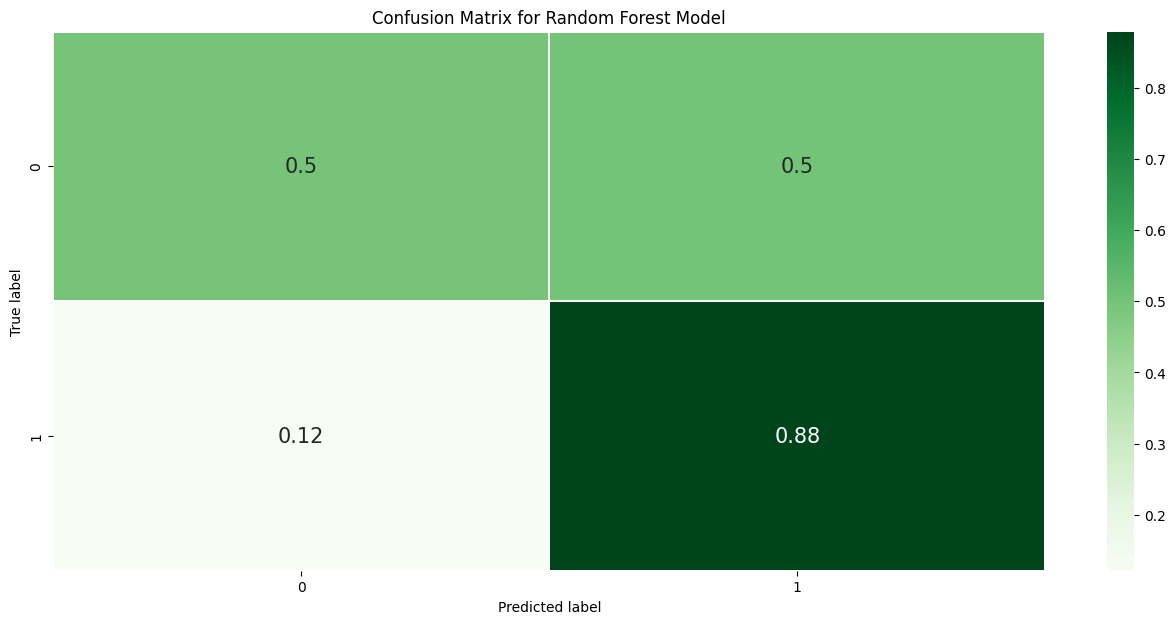

              precision    recall  f1-score   support

           0       0.75      0.50      0.60       577
           1       0.71      0.88      0.78       799

    accuracy                           0.72      1376
   macro avg       0.73      0.69      0.69      1376
weighted avg       0.73      0.72      0.71      1376



array([8.68769672e-02, 7.22697453e-02, 4.29156728e-02, 9.83681117e-02,
       8.37219528e-02, 3.20313185e-02, 3.24368980e-02, 1.22945323e-01,
       1.25601883e-01, 1.48188652e-01, 8.09030886e-03, 1.11811862e-03,
       2.34656040e-03, 7.12367734e-03, 1.40442307e-02, 9.87529231e-03,
       9.25996542e-03, 8.46987890e-03, 3.27168061e-03, 3.42305617e-04,
       2.01850243e-04, 3.18759571e-05, 0.00000000e+00, 8.16488267e-04,
       8.42331567e-05, 4.78000413e-05, 9.00243546e-04, 1.17887734e-04,
       8.50451973e-05, 2.73074203e-04, 0.00000000e+00, 7.61519020e-05,
       6.28750604e-04, 3.01967228e-04, 2.65554179e-04, 0.00000000e+00,
       9.44892801e-03, 5.98961198e-04, 4.72170175e-05, 2.45142650e-03,
       2.75983635e-03, 4.52859358e-04, 2.77979142e-03, 8.21266504e-03,
       0.00000000e+00, 3.32249824e-05, 1.47117299e-04, 1.39254396e-04,
       2.09076036e-04, 5.64755645e-04, 1.05846113e-03, 1.50141371e-04,
       7.55750626e-05, 1.66834256e-04, 1.63094108e-04, 3.45734230e-04,
      

The feature importance for duration_create_to_expire is : 0.08687696715946848
The feature importance for value_in_eth is : 0.07226974527721632
The feature importance for value_in_token is : 0.0429156728353922
The feature importance for value_in_usdt is : 0.09836811165925809
The feature importance for value_in_usdt_now is : 0.08372195276983962
The feature importance for project_length_code is : 0.03203131845713083
The feature importance for experience_level_code is : 0.03243689803044047
The feature importance for description_length is : 0.12294532312400358
The feature importance for duration_create_to_new_bounty is : 0.12560188276597992
The feature importance for token_value_in_usdt is : 0.148188652425999
The feature importance for bounty_type_Bug is : 0.008090308859708286
The feature importance for bounty_type_Code Review is : 0.0011181186220005467
The feature importance for bounty_type_Design is : 0.002346560402307635
The feature importance for bounty_type_Documentation is : 0.0071236

,Feature,Feature Importance
9,token_value_in_usdt,0.148189
8,duration_create_to_new_bounty,0.125602
7,description_length,0.122945
3,value_in_usdt,0.098368
0,duration_create_to_expire,0.086877
4,value_in_usdt_now,0.083722
1,value_in_eth,0.072270
2,value_in_token,0.042916
6,experience_level_code,0.032437
5,project_length_code,0.032031


In [14]:
#Setting 2 - without boothstrap

# Split dataset into features and target
y = new_raw_data_set2['is_success']
X = new_raw_data_set2.drop(['is_success','pk','github_comments','number_of_activities','number_of_fulfillments',
                       'number_of_interests','duration_create_to_done','duration_create_to_firstAct',
                       'duration_create_to_lastAct','duration_create_to_submitted','duration_create_to_killed',
                        'duration_create_to_start','duration_create_to_stop','duration_create_to_worker_applied',
                        'number_of_user_in_activities','changed_bounty_value','increased_bounty_times',
                      'firstAct_activity_type','lastAct_activity_type'], axis = 1).values

# Split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

# Instantiate and fit the RandomForestClassifier
forest = RandomForestClassifier(criterion='entropy', max_depth=25)
forest.fit(X_train, y_train)

# Make predictions for the test set
y_pred_test = forest.predict(X_test)

# View accuracy score
accuracy_score(y_test, y_pred_test)

# View confusion matrix for test data and predictions
confusion_matrix(y_test, y_pred_test)

# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.heatmap(matrix, annot=True, annot_kws={'size':15},
            cmap=plt.cm.Greens, linewidths=0.2)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# View the classification report for test data and predictions
print(classification_report(y_test, y_pred_test))

#-----------------------------------------------------------------------------------------------------------
forest.feature_importances_

#-------------------------------------------------------------------------------------------------------------
# Running Feature Importance

fi_col = []
fi = []

for i,column in enumerate(new_raw_data_set2.drop(['is_success','pk','github_comments','number_of_activities','number_of_fulfillments',
                       'number_of_interests','duration_create_to_done','duration_create_to_firstAct',
                       'duration_create_to_lastAct','duration_create_to_submitted','duration_create_to_killed',
                        'duration_create_to_start','duration_create_to_stop','duration_create_to_worker_applied',
                        'number_of_user_in_activities','changed_bounty_value','increased_bounty_times',
                        'firstAct_activity_type','lastAct_activity_type'], axis = 1)):
    
    print('The feature importance for {} is : {}'.format(column, forest.feature_importances_[i]))
    
    fi_col.append(column)
    fi.append(forest.feature_importances_[i])
    
# Creating a Dataframe
fi_df = zip(fi_col, fi)
fi_df = pd.DataFrame(fi_df, columns = ['Feature','Feature Importance'])
fi_df.sort_values('Feature Importance', ascending = False).head(10)

In [15]:
#https://towardsdatascience.com/point-biserial-correlation-with-python-f7cd591bd3b1

from scipy.stats import pointbiserialr

for x in bootstrapped_set2.drop(['is_success','pk','github_comments','number_of_activities','number_of_fulfillments',
                       'number_of_interests','duration_create_to_done','duration_create_to_firstAct',
                       'duration_create_to_lastAct','duration_create_to_submitted','duration_create_to_killed',
                        'duration_create_to_start','duration_create_to_stop','duration_create_to_worker_applied',
                        'number_of_user_in_activities','changed_bounty_value','increased_bounty_times',
                        'firstAct_activity_type','lastAct_activity_type'], axis = 1):
    print (x)
    pointbiserialr(bootstrapped_set2['is_success'], bootstrapped_set2[x])

duration_create_to_expire


PointbiserialrResult(correlation=-0.11643826376141982, pvalue=2.6104688868763394e-15)

value_in_eth


PointbiserialrResult(correlation=-0.02481587691271121, pvalue=0.09296403513593393)

value_in_token


PointbiserialrResult(correlation=-0.021668988013827488, pvalue=0.14240973138218166)

value_in_usdt


PointbiserialrResult(correlation=-0.028878387815874037, pvalue=0.050572121086745914)

value_in_usdt_now


PointbiserialrResult(correlation=-0.024648508429801357, pvalue=0.09519040603607896)

project_length_code


PointbiserialrResult(correlation=-0.04679616507376821, pvalue=0.001528497724610382)

experience_level_code


PointbiserialrResult(correlation=-0.10644676033143287, pvalue=4.989865653196229e-13)

description_length


PointbiserialrResult(correlation=-0.04802119362623376, pvalue=0.0011448472402905228)

duration_create_to_new_bounty


PointbiserialrResult(correlation=0.044507073361696646, pvalue=0.0025779897214193467)

token_value_in_usdt


PointbiserialrResult(correlation=-0.13945972956034072, pvalue=2.4014303093487113e-21)

bounty_type_Bug


PointbiserialrResult(correlation=-0.06957637230338212, pvalue=2.4157424298628857e-06)

bounty_type_Code Review


PointbiserialrResult(correlation=-0.021690619270626765, pvalue=0.14201165092454954)

bounty_type_Design


PointbiserialrResult(correlation=0.00447210518461298, pvalue=0.76211551926504)

bounty_type_Documentation


PointbiserialrResult(correlation=0.08187938329735825, pvalue=2.832696648717942e-08)

bounty_type_Feature


PointbiserialrResult(correlation=-0.04833859474793324, pvalue=0.0010611261889655228)

bounty_type_Improvement


PointbiserialrResult(correlation=0.010231131439339777, pvalue=0.48860426742615665)

bounty_type_NA


PointbiserialrResult(correlation=0.06398654172419595, pvalue=1.4543845788877408e-05)

bounty_type_Other


PointbiserialrResult(correlation=0.007198290501917887, pvalue=0.6260915150609291)

bounty_type_Security


PointbiserialrResult(correlation=-0.06761995706071414, pvalue=4.6006070302045135e-06)

token_name_0xBTC


PointbiserialrResult(correlation=-0.030497668125769907, pvalue=0.03894484620520469)

token_name_AEUR


PointbiserialrResult(correlation=-0.043144345357449626, pvalue=0.0034816899287845827)

token_name_AION


PointbiserialrResult(correlation=0.021473079342084905, pvalue=0.14605414103702402)

token_name_ALEX
/shared-libs/python3.9/py/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


PointbiserialrResult(correlation=nan, pvalue=nan)

token_name_ANT


PointbiserialrResult(correlation=0.007997081501571067, pvalue=0.5882971392521306)

token_name_AVO


PointbiserialrResult(correlation=0.017530782546101027, pvalue=0.23534858455343274)

token_name_BAND


PointbiserialrResult(correlation=0.017530782546101017, pvalue=0.23534858455348648)

token_name_BLZ


PointbiserialrResult(correlation=-0.06301949850572688, pvalue=1.956209459286065e-05)

token_name_BNB


PointbiserialrResult(correlation=0.012394782740057118, pvalue=0.40147203474170534)

token_name_BNT


PointbiserialrResult(correlation=-0.017603994493534093, pvalue=0.2333985050914154)

token_name_BORIS


PointbiserialrResult(correlation=-0.024898524313100145, pvalue=0.09188015587330385)

token_name_BRLN


PointbiserialrResult(correlation=0.012394782740057097, pvalue=0.40147203474170534)

token_name_BTC


PointbiserialrResult(correlation=-0.02489852431310014, pvalue=0.09188015587330385)

token_name_CBTX


PointbiserialrResult(correlation=0.010123197373870955, pvalue=0.4932024692291443)

token_name_CHI


PointbiserialrResult(correlation=-0.030497668125770004, pvalue=0.038944846205205)

token_name_CLN


PointbiserialrResult(correlation=0.007191850708981676, pvalue=0.6264004225134525)

token_name_COIN


PointbiserialrResult(correlation=0.012394782740057128, pvalue=0.40147203474170534)

token_name_DAI


PointbiserialrResult(correlation=0.10061481033896397, pvalue=8.63327280950517e-12)

token_name_DAT


PointbiserialrResult(correlation=-0.012824812102173087, pvalue=0.3853363515281894)

token_name_DATA


PointbiserialrResult(correlation=0.012394782740057123, pvalue=0.40147203474170534)

token_name_DIA


PointbiserialrResult(correlation=-0.0654474010787445, pvalue=9.220973726403222e-06)

token_name_DOT


PointbiserialrResult(correlation=-0.10301961270787668, pvalue=2.716243804184126e-12)

token_name_ENG


PointbiserialrResult(correlation=0.004149496852799958, pvalue=0.7788121939922605)

token_name_ETC


PointbiserialrResult(correlation=-0.08275988006319548, pvalue=2.0072235939446725e-08)

token_name_ETH


PointbiserialrResult(correlation=-0.025354064236599805, pvalue=0.08608687495691113)

token_name_FIL


PointbiserialrResult(correlation=-0.0176039944935341, pvalue=0.2333985050914154)

token_name_G$


PointbiserialrResult(correlation=nan, pvalue=nan)

token_name_GLM


PointbiserialrResult(correlation=-0.01760399449353408, pvalue=0.2333985050914154)

token_name_GLX


PointbiserialrResult(correlation=-0.017603994493534093, pvalue=0.2333985050914154)

token_name_GNO


PointbiserialrResult(correlation=0.021473079342084877, pvalue=0.14605414103702402)

token_name_HARBTY


PointbiserialrResult(correlation=-0.013174085636485044, pvalue=0.3725268850705264)

token_name_HERC


PointbiserialrResult(correlation=-0.05084464323677636, pvalue=0.0005737324204192572)

token_name_JAMM


PointbiserialrResult(correlation=-0.024898524313100134, pvalue=0.09188015587330385)

token_name_KEEP


PointbiserialrResult(correlation=0.012394782740057134, pvalue=0.40147203474170534)

token_name_KIWI


PointbiserialrResult(correlation=nan, pvalue=nan)

token_name_KNC


PointbiserialrResult(correlation=-0.024898524313100148, pvalue=0.09188015587330385)

token_name_KSM


PointbiserialrResult(correlation=-0.04660630966992378, pvalue=0.0015975916725008172)

token_name_LEAP


PointbiserialrResult(correlation=-0.017603994493534097, pvalue=0.2333985050914154)

token_name_LIKE


PointbiserialrResult(correlation=0.00414949685279997, pvalue=0.7788121939922605)

token_name_LINK


PointbiserialrResult(correlation=-0.03521951810018205, pvalue=0.017096050982625947)

token_name_LPT


PointbiserialrResult(correlation=-0.04148463552069618, pvalue=0.004966931755628008)

token_name_LRC


PointbiserialrResult(correlation=0.012394782740057106, pvalue=0.40147203474170534)

token_name_LUNA


PointbiserialrResult(correlation=-0.030497668125770042, pvalue=0.038944846205205)

token_name_MANA


PointbiserialrResult(correlation=0.02235622903951348, pvalue=0.13017547986967604)

token_name_MATIC


PointbiserialrResult(correlation=nan, pvalue=nan)

token_name_MESG


PointbiserialrResult(correlation=-0.005210917547907999, pvalue=0.7243038988373598)

token_name_MYB


PointbiserialrResult(correlation=-0.00036315444767683557, pvalue=0.9803893694815233)

token_name_NKN


PointbiserialrResult(correlation=-0.030497668125769983, pvalue=0.038944846205205)

token_name_NTV


PointbiserialrResult(correlation=0.017530782546101024, pvalue=0.23534858455343274)

token_name_OCEAN


PointbiserialrResult(correlation=0.005870197175028451, pvalue=0.6911181102777191)

token_name_ONE


PointbiserialrResult(correlation=-0.017603994493534135, pvalue=0.2333985050914154)

token_name_OTHER


PointbiserialrResult(correlation=nan, pvalue=nan)

token_name_PAN


PointbiserialrResult(correlation=-0.02489852431310013, pvalue=0.09188015587330385)

token_name_PBLC


PointbiserialrResult(correlation=-0.024898524313100134, pvalue=0.09188015587330385)

token_name_POLY


PointbiserialrResult(correlation=0.027727679645638888, pvalue=0.06049641350074585)

token_name_PROCN


PointbiserialrResult(correlation=0.02823525356532553, pvalue=0.055935935102734965)

token_name_RDN


PointbiserialrResult(correlation=0.02720851352013649, pvalue=0.06547549716905901)

token_name_REN


PointbiserialrResult(correlation=0.012394782740057122, pvalue=0.40147203474170534)

token_name_RHOC


PointbiserialrResult(correlation=-0.02595919828281261, pvalue=0.07885124699215487)

token_name_RLC


PointbiserialrResult(correlation=0.02479768300436603, pvalue=0.09320401160867069)

token_name_RLY


PointbiserialrResult(correlation=-0.000363154447676885, pvalue=0.9803893694815233)

token_name_SAI


PointbiserialrResult(correlation=0.04228175854069098, pvalue=0.00419390518553407)

token_name_SC


PointbiserialrResult(correlation=-0.0036838708834995423, pvalue=0.8030899035411615)

token_name_SGR


PointbiserialrResult(correlation=-0.017703779324250123, pvalue=0.23075911141994662)

token_name_SHIP


PointbiserialrResult(correlation=nan, pvalue=nan)

token_name_SNT


PointbiserialrResult(correlation=-0.009033466885963537, pvalue=0.5408959189359663)

token_name_SNX


PointbiserialrResult(correlation=0.018123832808147975, pvalue=0.21988099637446942)

token_name_ST


PointbiserialrResult(correlation=0.021473079342084922, pvalue=0.14605414103705633)

token_name_STORJ


PointbiserialrResult(correlation=-0.013981792569415563, pvalue=0.34392994260942145)

token_name_SWAGG


PointbiserialrResult(correlation=0.0214730793420849, pvalue=0.14605414103702402)

token_name_SYSX


PointbiserialrResult(correlation=0.012394782740057102, pvalue=0.40147203474170534)

token_name_TRB


PointbiserialrResult(correlation=-0.0073725704349781145, pvalue=0.6177566112688898)

token_name_TUSD


PointbiserialrResult(correlation=-0.046606309669923775, pvalue=0.0015975916725008172)

token_name_USD


PointbiserialrResult(correlation=-0.0012227040348880107, pvalue=0.9340416370432334)

token_name_USDC


PointbiserialrResult(correlation=-0.047247493497591164, pvalue=0.0013751458566747716)

token_name_USDT


PointbiserialrResult(correlation=-0.06998942049303561, pvalue=2.1039386142697207e-06)

token_name_WBTC


PointbiserialrResult(correlation=-0.017603994493534083, pvalue=0.2333985050914154)

token_name_WYV


PointbiserialrResult(correlation=-0.005210917547908013, pvalue=0.7243038988373598)

token_name_XRT


PointbiserialrResult(correlation=nan, pvalue=nan)

token_name_ZIL


PointbiserialrResult(correlation=-0.03521951810018204, pvalue=0.017096050982625947)

token_name_ZRX


PointbiserialrResult(correlation=-0.00638343845809107, pvalue=0.6656841504209386)

token_name_aDAI


PointbiserialrResult(correlation=0.03923428723142635, pvalue=0.00789177343638703)

token_name_cUSD


PointbiserialrResult(correlation=0.017530782546101045, pvalue=0.23534858455343274)

token_name_wNXM


PointbiserialrResult(correlation=-0.030497668125769973, pvalue=0.03894484620520469)

project_type_contest


PointbiserialrResult(correlation=0.08868139781143577, pvalue=1.805424449173704e-09)

project_type_cooperative


PointbiserialrResult(correlation=-0.11423697407215896, pvalue=8.645611786970871e-15)

project_type_traditional


PointbiserialrResult(correlation=-0.005270528269310834, pvalue=0.7212807982936914)

In [16]:
# import pandas as pd
# from scipy.stats import pointbiserialr


# # # number of features
# num_features = 10
# # # significance level
# alpha = 0.05
# # # corrected significance level
# alpha_corrected = alpha / num_features

# # # Create an empty DataFrame to store the results
# results = pd.DataFrame(columns=['Feature','Correlation','P-value'])

# for x in bootstrapped_set2.drop(['is_success','pk'], axis = 1):
#     pbs = pointbiserialr(bootstrapped_set2['is_success'], bootstrapped_set2[x])
#     if pbs.pvalue < alpha_corrected:
#         results = results.append({'Feature': x, 'Correlation': pbs.correlation, 'P-value': pbs.pvalue}, ignore_index=True)

# # results.to_csv('point_biserial_correlation_results_setting_2.csv', index=False)

In [17]:
new_raw_data_set2


,pk,is_success,duration_create_to_expire,value_in_eth,value_in_token,value_in_usdt,value_in_usdt_now,project_length_code,experience_level_code,github_comments,number_of_activities,number_of_fulfillments,number_of_interests,description_length,duration_create_to_done,duration_create_to_firstAct,duration_create_to_lastAct,duration_create_to_submitted,duration_create_to_killed,duration_create_to_new_bounty,duration_create_to_start,duration_create_to_stop,duration_create_to_worker_applied,number_of_user_in_activities,changed_bounty_value,increased_bounty_times,firstAct_activity_type,lastAct_activity_type,token_value_in_usdt,bounty_type_Bug,bounty_type_Code Review,bounty_type_Design,bounty_type_Documentation,bounty_type_Feature,bounty_type_Improvement,bounty_type_NA,bounty_type_Other,bounty_type_Security,token_name_0xBTC,token_name_AEUR,token_name_AION,token_name_ALEX,token_name_ANT,token_name_AVO,token_name_BAND,token_name_BLZ,token_name_BNB,token_name_BNT,token_name_BORIS,token_name_BRLN,token_name_BTC,token_name_CBTX,token_name_CHI,token_name_CLN,token_name_COIN,token_name_DAI,token_name_DAT,token_name_DATA,token_name_DIA,token_name_DOT,token_name_ENG,token_name_ETC,token_name_ETH,token_name_FIL,token_name_G$,token_name_GLM,token_name_GLX,token_name_GNO,token_name_HARBTY,token_name_HERC,token_name_JAMM,token_name_KEEP,token_name_KIWI,token_name_KNC,token_name_KSM,token_name_LEAP,token_name_LIKE,token_name_LINK,token_name_LPT,token_name_LRC,token_name_LUNA,token_name_MANA,token_name_MATIC,token_name_MESG,token_name_MYB,token_name_NKN,token_name_NTV,token_name_OCEAN,token_name_ONE,token_name_OTHER,token_name_PAN,token_name_PBLC,token_name_POLY,token_name_PROCN,token_name_RDN,token_name_REN,token_name_RHOC,token_name_RLC,token_name_RLY,token_name_SAI,token_name_SC,token_name_SGR,token_name_SHIP,token_name_SNT,token_name_SNX,token_name_ST,token_name_STORJ,token_name_SWAGG,token_name_SYSX,token_name_TRB,token_name_TUSD,token_name_USD,token_name_USDC,token_name_USDT,token_name_WBTC,token_name_WYV,token_name_XRT,token_name_ZIL,token_name_ZRX,token_name_aDAI,token_name_cUSD,token_name_wNXM,project_type_contest,project_type_cooperative,project_type_traditional
0,10129,0,0.000052,0.000040,2.541672e-08,0.000020,0.000040,24,2,0.021277,0.0125,0.000000,0.000000,0.031900,0.000000,0.001305,0.229128,0.000000,0.002634,0.355576,0.000062,0.002249,0.000831,0.011765,0.000045,0.0,new_bounty,unknown_event,0.008116,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,10131,1,0.003145,0.000016,1.361610e-05,0.000036,0.000016,168,2,0.170213,0.0275,0.006410,0.006024,0.038907,0.058051,0.001459,0.447560,0.048856,0.000000,0.397626,0.000000,0.011923,0.005511,0.017647,0.000045,0.0,new_bounty,work_submitted,0.000028,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,10132,1,0.003145,0.000051,4.538699e-05,0.000121,0.000052,0,0,0.212766,0.0600,0.012821,0.006024,0.167009,0.067483,0.001309,0.447490,0.063978,0.000000,0.356550,0.000000,0.000000,0.003411,0.011765,0.000045,0.0,new_bounty,work_submitted,0.000028,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,10134,1,0.003145,0.000004,3.177090e-06,0.000008,0.000004,0,0,0.085106,0.0150,0.006410,0.006024,0.010917,0.001697,0.001305,0.447446,0.000761,0.000000,0.355501,0.000007,0.000000,0.000831,0.011765,0.000045,0.0,new_bounty,work_submitted,0.000028,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,10135,1,0.000052,0.000057,3.630959e-08,0.000028,0.000058,1,2,0.00

In [18]:
y = new_raw_data_set2['is_success']
X = new_raw_data_set2.drop(['is_success','pk','github_comments','number_of_activities','number_of_fulfillments',
                       'number_of_interests','duration_create_to_done','duration_create_to_firstAct',
                       'duration_create_to_lastAct','duration_create_to_submitted','duration_create_to_killed',
                        'duration_create_to_start','duration_create_to_stop','duration_create_to_worker_applied',
                        'number_of_user_in_activities','changed_bounty_value','increased_bounty_times',
                      'firstAct_activity_type','lastAct_activity_type'], axis = 1).values

# Split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

LogisticRegression()

0.5712209302325582

array([[ 91, 486],
       [104, 695]])

<Figure size 1600x700 with 0 Axes>

<AxesSubplot: >

Text(0.5, 47.7222222222222, 'Predicted label')

Text(170.72222222222223, 0.5, 'True label')

Text(0.5, 1.0, 'Confusion Matrix for Random Forest Model')

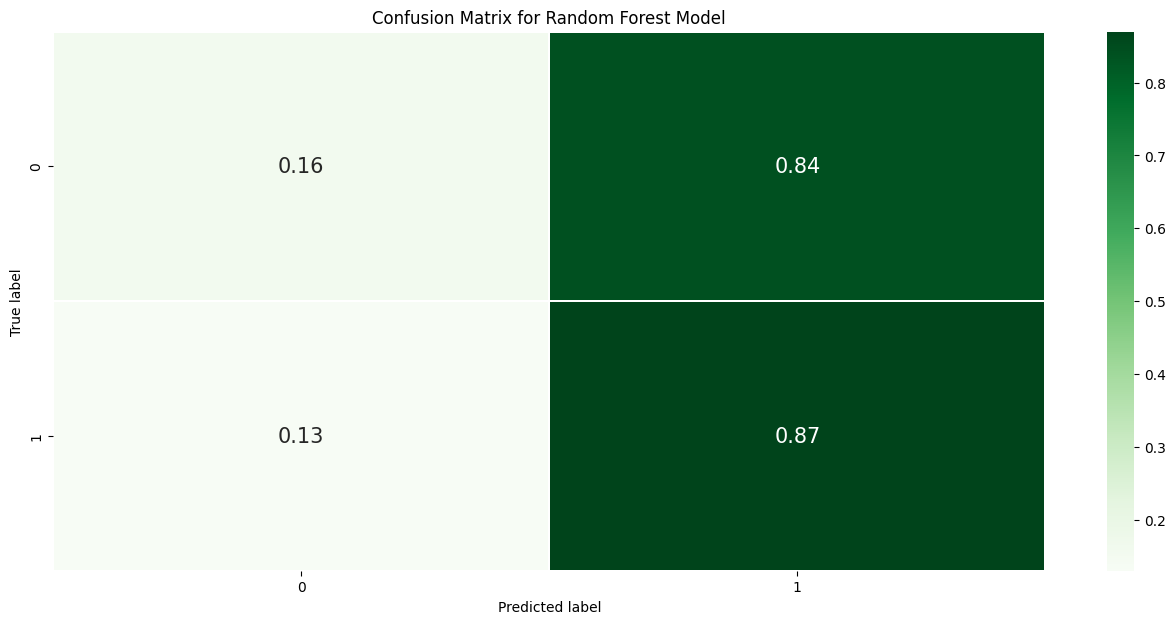

              precision    recall  f1-score   support

           0       0.47      0.16      0.24       577
           1       0.59      0.87      0.70       799

    accuracy                           0.57      1376
   macro avg       0.53      0.51      0.47      1376
weighted avg       0.54      0.57      0.51      1376



In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold

# Split dataset into features and target
y = new_raw_data_set2['is_success']
X = new_raw_data_set2.drop(['is_success','pk','github_comments','number_of_activities','number_of_fulfillments',
                       'number_of_interests','duration_create_to_done','duration_create_to_firstAct',
                       'duration_create_to_lastAct','duration_create_to_submitted','duration_create_to_killed',
                        'duration_create_to_start','duration_create_to_stop','duration_create_to_worker_applied',
                        'number_of_user_in_activities','changed_bounty_value','increased_bounty_times',
                      'firstAct_activity_type','lastAct_activity_type'], axis = 1)

# remove multicollinearity
threshold = 0.8
vt = VarianceThreshold().fit(X)

# Find feature names
feat_var_threshold = X.columns[vt.variances_ > threshold * (1-threshold)]
X = X[feat_var_threshold]

# Split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

# Instantiate and fit the LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Make predictions for the test set
y_pred_test = logreg.predict(X_test)

# View accuracy score
accuracy_score(y_test, y_pred_test)

# View confusion matrix for test data and predictions
confusion_matrix(y_test, y_pred_test)

# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.heatmap(matrix, annot=True, annot_kws={'size':15},
            cmap=plt.cm.Greens, linewidths=0.2)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# View the classification report for test data and predictions
print(classification_report(y_test, y_pred_test))

In [20]:
# Get the coefficients of the model
coefs = logreg.coef_[0]

# Create a dataframe of the feature names and coefficients
coef_df = pd.DataFrame({'feature': X_train.columns, 'coef': coefs})

# Sort the dataframe by absolute value of the coefficients
coef_df = coef_df.sort_values(by='coef', ascending=False)

# Print the top 10 features with the highest absolute value of coefficients
print(coef_df.head(10))

                    feature      coef
4            token_name_DAI  0.657037
5            token_name_ETH  0.150644
0       project_length_code -0.001066
2       bounty_type_Feature -0.007045
3            bounty_type_NA -0.122878
6  project_type_traditional -0.129555
1     experience_level_code -0.195637


In [21]:
!pip install statsmodels==0.13.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 KB 33.3 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [22]:
import statsmodels.api as sm

# Fit the logistic regression model using statsmodels
logreg_sm = sm.Logit(y_train, sm.add_constant(X_train)).fit()

# Perform the Wald test
wald_test_results = logreg_sm.wald_test_terms()

# Print the results
print(wald_test_results)

Optimization terminated successfully.
         Current function value: 0.668941
         Iterations 5
                                              chi2                  P>chi2  df constraint
const                       [[12.905776718153431]]   0.0003275695716916349              1
project_length_code          [[3.222758941390981]]     0.07262113511191381              1
experience_level_code       [[14.221730605562433]]  0.00016248328698173292              1
bounty_type_Feature       [[0.008675354250802453]]      0.9257910835386869              1
bounty_type_NA               [[1.154555114786528]]     0.28259763072539634              1
token_name_DAI               [[37.91429637298182]]   7.392156010593601e-10              1
token_name_ETH               [[2.782807358968975]]      0.0952810202255956              1
project_type_traditional     [[2.522492026264633]]     0.11223309480757841              1
/root/venv/lib/python3.9/site-packages/statsmodels/base/model.py:1889: FutureWarning: Th

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c7dbb46d-be11-4d98-a8ae-f659e78e24c4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>